In [2]:
%matplotlib inline

<!-- omit in toc -->
# questions

* programme python qui prend une image array en entrée ?  
  terminal script.py + argument par ex l'image  
  $ python script.py --file pah_to_image.png  
  argparse librairie (pré installée)  
* sur colab comment importer sa bdd ?
* keras.Input ?
* Faut il faire train/test/validation ? Si oui comment ?

<!-- omit in toc -->
# Classez des images à l'aide d'algorithmes de Deep Learning

<!-- omit in toc -->
# sommaire

- [1. Problématique](#1-problématique)

# 1. Problématique

Obtenir un algorithme capable de **classer les images en fonction de la race du chien** présent sur l'image.  

C'est un exercice de **classification supervisée** dans le domaine de la **computer vision**.  

## 1.1 Processus envisagé

**Pré-processer** les images  
Utilisation de techniques spécifiques (e.g. whitening, equalization, data augmentation, modification de la taille des images).  


Approches en s’appuyant sur l’état de l’art et l’utilisation de **CNN (réseaux de neurones convolutif)**  
A comparer en termes de temps de traitement et de résultat  

Réaliser d'abord un **réseau CNN from scratch**, en s'inspirant de réseaux CNN existants.  
Optimisation de certains hyperparamètres (des layers du modèle, de la compilation du modèle et de l’exécution du modèle)  

**transfer learning**  
Utiliser un réseau déjà entraîné, et en le modifiant pour répondre au problème.  

Il faudra réentraîner les dernières couches pour prédire les classes qui nous intéressent seulement.  
> Il est également possible d’adapter la structure (supprimer certaines couches, par exemple) ou de réentraîner le modèle avec un très faible learning rate pour ajuster les poids à votre problème (plus long) et optimiser les performances.



Limitez le jeu de données, en ne sélectionnant que quelques classes (races de chiens), ce qui permettra déjà de tester la démarche et la conception des modèles, avant une éventuelle généralisation.  

comparer CNN  et transfer learning 

accuracy score pour évaluer ?
mesurer l'apport du preprocessing dans les resultats du modèle

Simulations pour opti le modèle (layers, etc)
Limiter le nb de classes pour réduire tps de traitement

sélectionner un modèle DL adapté
Champ d'application de classification
Au moins 2 modèles CNN 
au moins un modèle CNN transfer learning tel que VGG16, ResNet50, ou Inception ResNetV2

séparation train, test (mais sans sklearn ?)

kernel size, drop out, methode activation layer final
Expliquer au fur et à mesure ce qui est utilisé

adapter
optimizer, loss, sgd adam
batch size, nb d'epochs

résultats comparés de manière auto

transformation des variables
cropping, whitening, equalizer, débruitage, redimentionnement, miroring

montrer un exmple avant/après pour un des traitements

## 1.2 Flowchart



# 2. Cleaning/Exploration

## 2.1 Librairies

In [81]:
# Generic librairies
import numpy as np
import pandas as pd
import os
import random
import xml.etree.ElementTree as ET
import timeit

# images librairies
import cv2 as cv# OpenCV
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import tensorflow as tf
from tensorflow import keras

# # For jupyter NB users 
# # set size of window
# display(HTML(data="""
# <style>
#     div#notebook-container    { width: 95%; }
#     div#menubar-container     { width: 65%; }
#     div#maintoolbar-container { width: 99%; }
# </style>
# """))

Les exercices de classification en computer vision demandent beaucoup de ressources.  
Effectuer les calcul grâce à un processeur graphique accèlere significativement les calculs.

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## 2.2 Variables

In [79]:
# env could be 'local', 'colab, 'kaggle'
env = 'local'

if env == 'local':
    ini_img_dir = "../data/images/"
    bnd_box_annotations_path = '../data/annotation/'

    resized_dir = '../data/imgs_rzd/'
    cropped_dir = '../data/imgs_crp/'

elif env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    ini_img_dir = "/content/drive/MyDrive/30_MachineLearning/images/"
    bnd_box_annotations_path = '/content/drive/MyDrive/30_MachineLearning/annotation/'

    resized_dir = '/content/drive/MyDrive/30_MachineLearning/imgs_rzd/'
    cropped_dir = '/content/drive/MyDrive/30_MachineLearning/imgs_crp/'

elif env == 'kaggle':
    ini_img_dir = "../input/stanford-dogs-dataset/images/Images/"
    bnd_box_annotations_path = '../input/stanford-dogs-dataset/annotations/Annotation/'

    resized_dir = './imgs_rzd/'
    cropped_dir = './imgs_crp/'
    
# as we'll usue VGG16 later we will preprocess the images with the size it needs.
height=224
width=224

breed_list = os.listdir(ini_img_dir)
nb_breed = len(breed_list)

## 2.3 Exploration

Notre jeu de donnée est le Stanford Dogs Dataset.  
Il est téléchargeable à cette adresse :  
>http://vision.stanford.edu/aditya86/ImageNetDogs/

Il est constitué de photos de chiens qui sont classées par race.  
Il existe un sous dossier par race.

Etudions la quantité de données disponible :

In [5]:
n_tot_img = 0
img_per_breed = []
for breed in breed_list:
    nb_img = len(os.listdir(ini_img_dir + breed))
    n_tot_img += len(os.listdir(ini_img_dir + breed))
    img_per_breed.append(nb_img)
    
print("Nous avons {} races et {} images.\nCela fait {} images/race en moyenne".format(nb_breed, n_tot_img, round(n_tot_img/nb_breed)))

Nous avons 120 races et 20580 images.
Cela fait 172 images/race en moyenne


## 2.4 Distribution

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(img_per_breed, bins=30)
plt.title('Distribution du nombre d\'image par race')
if env == 'local':
    plt.savefig('../img/distri_img.png')
plt.show()

In [7]:
print("Nombre minimum d'images dans une classe : {}".format(min(img_per_breed)))

Nombre minimum d'images dans une classe : 148


## 2.5 Echantillon d'images

In [8]:
def show_images_sample(nb_breed_to_show):
    '''show 4 firsts images of nb_breed_to_show breed choosen randomly'''

    nb_breed_to_show = int(nb_breed_to_show)

    plt.figure(figsize=(16,nb_breed_to_show*4))

    # fig.suptitle(breed, fontsize=20)
    for i in range(nb_breed_to_show):
        breed = random.choice(breed_list)
        img_dir = ini_img_dir + breed
        images = os.listdir(img_dir)[:4] # select 4 first images names

        for image_nb in range(4):
            plt.subplot(nb_breed_to_show, 4, (image_nb+1)+4*(i))
            img = mpimg.imread(img_dir + '/' + images[image_nb])
            plt.imshow(img)
            if image_nb == 0: # title only one the 1st image
                plt.title(breed)
            plt.axis('off')

In [10]:
show_images_sample(2)

## 2.6 Filtre images corrompues

Nous travaillons avec de nombreuses données d'images du monde réel, les images corrompues sont un phénomène courant.  
Filtrons les images mal encodées qui ne comportent pas la chaîne "JFIF" dans leur en-tête.

Déterminons tout d'abord si nous avons des images corrompues.  
Si c'est le cas nous les supprimerons après preprocessing si nécessaire.

In [11]:
def filter_corrupted(initial_path, remove=False):
    num_skipped = 0
    for folder_name in os.listdir(initial_path):
        folder_path = os.path.join(initial_path, folder_name)
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)
            try:
                fobj = open(fpath, "rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            finally:
                fobj.close()

            if not is_jfif:
                num_skipped += 1
                if remove:
                    os.remove(fpath)

    print("%d images corrompues" % num_skipped)

In [12]:
filter_corrupted(ini_img_dir)

10 images corrompues


# 3. Preprocessing

## 3.1 Resize / crop


Nous allons commencer par définir des fonctions permettant de changer la taille de nos images et de les recadrer grâces aux bounding box fournies avec le dataset.

In [31]:
def resize_img(img_path, height=height, width=width, bnd_box_annotations_path=None, method='pillow'):
    '''resize one image to height x width pixels return the image
    If bnd_box_annotations_path!=None it will select the proper box and then crop the image before the resize
    image path and annotations must have the same subdirectories and files names (except for file extension)
    method could be pillow (import Image) or opencv (as cv)
    '''
    if method == 'opencv':
        img = cv.imread(img_path, cv.IMREAD_UNCHANGED)
    else:
        img = Image.open(img_path) # pillow library

    # this part extrat the bounding box dimensions from annotation folder
    if bnd_box_annotations_path!=None:
        path_no_extension = os.path.splitext(img_path)[0]
        file_name = os.path.split(path_no_extension)[1]
        # take the breed from the initial image path
        breed = os.path.split(os.path.split(path_no_extension)[0])[1]
        img_annotation_dir = bnd_box_annotations_path + '{}/{}'.format(breed, file_name)
        tree = ET.parse(img_annotation_dir)
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)

        if method == 'opencv':
            img = img[ymin:ymax, xmin:xmax]
        else:
            img = img.crop((xmin, ymin, xmax, ymax))

    if method == 'opencv':
        img = cv.resize(img, (height, width), interpolation=cv.INTER_LINEAR)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    else:
        img = img.convert('RGB')
        img = img.resize((height, width))
    return img

In [ ]:

# Depreciated
def all_dataset(function_to_apply, initial_path, saving_path, height=height, width=width, bnd_box_annotations_path=None):
    '''apply a function to our entire dataset 
    save new data to saving_path keeping same directories
    '''
    try:
        os.mkdir(saving_path)
    except FileExistsError:
        pass

    breed_list = os.listdir(initial_path)

    for breed in breed_list:
        breed_path = saving_path + breed
        try:
            os.mkdir(breed_path)
        except FileExistsError:
            pass

        # list of img names with extentions
        breed_file_list = os.listdir(initial_path + breed)

        for file in breed_file_list:
            img_path = initial_path + '{}/{}'.format(breed, file)
            img = function_to_apply(img_path, height, width, bnd_box_annotations_path)
            img.save(saving_path + '{}/{}'.format(breed, file))


In [5]:
# all_dataset(resize_img, ini_img_dir, resized_dir) # depreciated since we don't need to store it, it's an argument on image loader
# all_dataset(resize_img, ini_img_dir, cropped_dir, bnd_box_annotations_path=bnd_box_annotations_path) # I will probably store the image in a variable strait after the cropping

In [11]:
# filter_corrupted(resized_dir)
# filter_corrupted(cropped_dir)

0 images corrompues
0 images corrompues


In [34]:
def random_img(ini_img_dir=ini_img_dir, breed_list=breed_list):
    '''return a random image path from our dataset'''
    breed = random.choice(breed_list)
    breed_path = ini_img_dir + breed
    image = random.choice(os.listdir(breed_path))
    image_path = breed_path + '/' + image
    return image_path

In [48]:
def show_dif_size_img(ini_img_dir=ini_img_dir):

    image_path = random_img(ini_img_dir)

    fig = plt.figure(figsize=(16, 6))
    fig.suptitle('Images after size preprocessing', fontsize=16)

    # for i in range(3):
    plt.subplot(1, 3, 1)
    img = mpimg.imread(image_path)
    plt.title("Original shape : {}".format(img.shape))
    plt.imshow(img)

    plt.subplot(1, 3, 2)
    img = resize_img(image_path, method='opencv')
    plt.title("Resized shape : {}".format(img.shape))
    plt.imshow(img)

    plt.subplot(1, 3, 3)
    img = resize_img(image_path, bnd_box_annotations_path=bnd_box_annotations_path, method='opencv')
    plt.title("Cropped and resized shape : {}".format(img.shape))
    plt.imshow(img)

    plt.axis('off')

In [49]:
show_dif_size_img()

## 3.2 whitening

Dans les images naturelles, les pixels ont tendance à être corrélés avec leurs voisins.  
Le whitening supprime ces corrélations.

L'application du whitening PCA a pour effet de normaliser les images pour les écarts naturels.  
Cette normalisation améliore la précision des comparaisons que nous effectuons entre différentes parcelles d'image en utilisant la distance euclidienne.  
La distance entre les taches blanchies est une bien meilleure mesure de leur similitude que la distance entre les taches non blanchies. 

Nous utilisons d'abord l'ACP pour trouver les directions de variance et projeter les données dans ces directions.  
Ensuite, nous pouvons facilement normaliser la variance. 

L'étape de blanchiment effectue une extraction de caractéristiques qui, dans cet exemple, donne à la comparaison de distance une certaine invariance par rapport aux changements de luminosité.

<img src="..\img\pixel_4_5_correlation.png" width="400px"><img src="..\img\pixel_4_5_correlation_after_whiten.png" width="400px">    

Nous utiliserons le whitening à partir de la méthode Keras permettant de faire de la data augmentation.

## 3.3 histogram equalization

L'histogramme d'une image numérique est une courbe statistique représentant la répartition de ses pixels selon leur intensité.  
Commençons par regarder une image en particulier.

Nous allons transformer l'image dans différents codages couleurs.  
Le système de codage YUV est créé depuis une source RVB. Il est codé en trois composantes : 
- Y représente la luminance (informations de luminosité) 
- U et V sont des données de chrominance (informations de couleur).  
Ce format nous permet de visualiser au mieux l'histogramme pour les 3 dimensions.

**Egalisation**  
On constate régulièrement des pics importants de l'histogram.  
Dans le cadre d'une bonne égalisation (amélioration du contraste), il est nécessaire de répartir la lumière dans tout le spectre de l'image.

Nous utiliserons OpenCV pour l'égalisation.  
L'intérêt de convertir l'image dans l'espace colorimétrique YUV est de pouvoir agir sur le canal "luminance" (Y) indépendamment des autres canaux de chrominance.  
Nous allons donc réaliser l'égalisation sur ce seul canal Y

In [39]:
def equalize(img):
    '''initial and final image in RGB'''
    img_YUV = cv.cvtColor(img,cv.COLOR_RGB2YUV)
    img_YUV[:,:,0] = cv.equalizeHist(img_YUV[:,:,0])
    img_equ = cv.cvtColor(img_YUV, cv.COLOR_YUV2RGB)
    return img_equ

In [51]:
def show_histo_img(ini_img_dir=ini_img_dir):

    image_path = random_img(ini_img_dir)

    fig = plt.figure(figsize=(16, 8))
    fig.suptitle('Images after equalization preprocessing', fontsize=16)
    fig.tight_layout()

    # for i in range(3):
    plt.subplot(2, 3, 1)
    img = mpimg.imread(image_path)
    plt.title("Original image")
    plt.imshow(img)

    plt.subplot(2, 3, 2)
    plt.title("Original image YUV")
    plt.imshow(cv.cvtColor(img,cv.COLOR_RGB2YUV))

    plt.subplot(2, 3, 3)
    plt.title("Original image histogram")
    vals = img.mean(axis=2).flatten()
    # plot histogram with 255 bins
    b, bins, patches = plt.hist(vals, 255)
    plt.xlim([0,255])

    plt.subplot(2, 3, 4)
    img = equalize(img)
    plt.title("Equalized image")
    plt.imshow(img)

    plt.subplot(2, 3, 5)
    plt.title("Equalized image YUV")
    plt.imshow(cv.cvtColor(img,cv.COLOR_RGB2YUV))

    plt.subplot(2, 3, 6)
    plt.title("Equalized image histogram")
    vals = img.mean(axis=2).flatten()
    # plot histogram with 255 bins
    b, bins, patches = plt.hist(vals, 255)
    plt.xlim([0,255])

    plt.axis('off')

In [52]:
show_histo_img()

## 3.4 data augmentation

Le risque sur ce type de dataset comportant peu de données (20 000 images) est de sur-entrainer notre modèle.  
Il ne pourra pas développer des règles de décisions pouvant être généralisé à de nouvelles données.  
Il faut donc augmenter le nombre de data et pour cela, nous allons utiliser la Data Augmentation.

L'objectif de la data augmentation est d'augmenter artificiellement la quantité de données en leur appliquant une transformation aléatoire.  
Pour cela, Keras mets à disposition la méthode ImageDataGenerator qui permet de faire à la fois du mirroring, de la rotation, des zoom de manière aléatoire !

In [53]:
from tensorflow.keras.applications.efficientnet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

val_split = .2
zca_epsilon = 1e-6
zca_whitening = True

In [68]:
def data_generator(val_split, zca_whitening=False, zca_epsilon=1e-06):
        data_gen = ImageDataGenerator(
                shear_range=0.1,
                rotation_range=30,
                zoom_range=0.1,
                brightness_range=[0.9,1.1],
                horizontal_flip=True,
                validation_split=val_split,
                preprocessing_function=preprocess_input,
                zca_whitening=zca_whitening,
                zca_epsilon=zca_epsilon
                )
        return data_gen

# We create 2 differents objects for the data augmentation
data_gen = data_generator(val_split)
data_gen_wh = data_generator(val_split, zca_whitening, zca_epsilon)

C:\Users\Admin\miniconda3\envs\env_p6\lib\site-packages\keras_preprocessing\image\image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [75]:
def show_data_gen(data_gen=data_gen, ini_img_dir=ini_img_dir):
    image_path = random_img(ini_img_dir)
    img = mpimg.imread(image_path)

    # Convert test img to array
    x = keras.preprocessing.image.img_to_array(img)
    x = x.reshape((1,) + x.shape)

    fig = plt.figure(figsize=(14,10))
    for i, batch in zip(range(12), data_gen.flow(x, batch_size=1)):
        ax = fig.add_subplot(3,4,i+1)
        ax.imshow(keras.preprocessing.image.array_to_img(batch[0]))


    plt.suptitle("Data Augmentation with Keras",
                color="black", 
                fontsize=22, y=.90)
    plt.show()

In [77]:
show_data_gen(data_gen=data_gen)

In [15]:
# image_classification_from_scratch
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1)
    ]
)

## 3.5 Preprocessing final

In [80]:
def preprocessing_img(img_folder=ini_img_dir, height=height, width=width, bbx_annot=None, equalization=True, nb_breed=None):
    """Preprocessing of images in order to integrate them 
    into a convolutional neural network. 
    Resizing, equalization and transformation of the image into Array. 
    Simultaneous creation of labels (y). 

    Parameters
    ---------------------------------------------------
    folder : str
        Initial folder with images
    width : integer
        width of the image to be reached for resizing
    height : integer
        height of the image to be reached for resizing
    bbx_annot : str
        path for annotation folder for bounding box crop
    equalization : bool
        activate or not the equalization
    nb_breed : int
        number of breeds to treat
        by default len(os.listdir(img_folder))
    ---------------------------------------------------
    """
    img_list=[]
    labels=[]
    if nb_breed = None:
        nb_breed = len(os.listdir(img_folder))
        
    breeds = os.listdir(img_folder)[:nb_breed]
    for index, breed in enumerate(breeds):
        for image_name in os.listdir(img_folder + "/" + breed):

            img_path = img_folder + "/" + breed + "/" + image_name

            # img = cv.imread(images_dir+"/"+breed+"/"+image_name)
            # img = cv.cvtColor(img,cv.COLOR_BGR2RGB)

            # Resize image
            img = resize_img(img_path, height, width, bnd_box_annotations_path=bbx_annot, method='opencv')
            
            # Equalization
            if equalization:
                img = equalize(img)
            
            # Convert modified img to array
            img_array = keras.preprocessing.image.img_to_array(img)
            
            # Append lists of labels and images
            img_list.append(np.array(img_array))
            labels.append(breed.split("-")[1])
    
    return img_list, labels

In [ ]:
# Define numbers of breeds to preprocess (from 2 to 120)
num_breeds = 15 
breeds = breed_list[:num_breeds]

# Execute preprocessor on selection
start_time = timeit.default_timer()
# X = images
# y = labels
X, y = preprocessing_cnn(breeds, 299, 299)
# Convert in numpy array
X = np.array(X)
y = np.array(y)
preprocess_time = timeit.default_timer() - start_time
print("-" * 50)
print("Execution time for preprocessing :")
print("-" * 50)
print("Number of images preprocessed : {}"\
     .format(len(y)))
print("Shape of images np.array : {}"\
     .format(X.shape))
print("Total time : {:.2f}s".format(preprocess_time))


# 4. CNN spécifique

Nous allons tout d'abord créer un réseau de neuronne convolutif entier avant de l'entrainer et de le tester


## 4.1 Création du model

### Loading dataset and labels

In [56]:
batch_size = 64

# learning_rate = 0.0001
# classes = 120
seed = 42

In [57]:
def split_train_val(folder, val_split, batch_size, height, width, seed=None, data_gen=None):
    if data_gen is None:
        train_ds = keras.preprocessing.image_dataset_from_directory(
            folder,
            labels='inferred',
            batch_size=batch_size,
            image_size=(height, width),
            validation_split=val_split,
            subset='training',
            seed=seed)

        val_ds = keras.preprocessing.image_dataset_from_directory(
            folder,
            labels='inferred',
            batch_size=batch_size,
            image_size=(height, width),
            validation_split=val_split,
            subset='validation',
            seed=seed)
    
    else:
        train_ds = data_gen.flow_from_directory(
            folder,
            target_size=(height, width),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True,
            seed=seed,
            subset="training"
            )

        val_ds = data_gen.flow_from_directory(
            folder,
            target_size=(height, width),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False,
            seed=seed,
            subset="validation"
            )

    return train_ds, val_ds

In [58]:

# train_ds, val_ds = split_train_val(resized_dir, val_split, batch_size, height, width, seed) #depreciated
train_ds_gen, val_ds_gen = split_train_val(resized_dir, val_split, batch_size, height, width, seed, data_gen)
train_ds_gen_wh, test_ds_gen_wh = split_train_val(resized_dir, val_split, batch_size, height, width, seed, data_gen_wh)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.
Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [59]:
train_ds, val_ds = split_train_val(ini_img_dir, val_split, batch_size, height, width, seed)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


Sortir 5-10% des images pour le test, les mettre dans un autre rep

### Train sample with labels

In [60]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Train sample with data augmentation

In [61]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(6):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

NameError: name 'data_augmentation' is not defined

<Figure size 720x720 with 0 Axes>

### Depreciated

In [6]:
breed_list = os.listdir(resized_img_dir)

label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

def paths_and_labels(img_dir):
    '''Create lists with respectivly paths, labels, and label number of files'''

    paths = list()
    labels = list()
    targets = list()

    for breed in breed_list:
        breed_dir = img_dir +'{}/'.format(breed)
        breed_img_list = os.listdir(breed_dir)

        for img_name in breed_img_list:
            paths.append(breed_dir + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

paths, labels, targets = paths_and_labels(resized_img_dir)

assert len(paths) == len(labels)
assert len(paths) == len(targets)

# clarifier label/target (un seul nom)
# liste pour les labels ok

In [15]:
# import

# enregistrer les images dans une variable en 4D

def load_imgs(paths):
	"""Load all images in paths list and return a list"""
	loaded_images = []
	for path in paths:
		# load image
		img_data = mpimg.imread(path)
		# store loaded image
		loaded_images.append(img_data)
	print('> loaded {} images.'.format(len(loaded_images)))
	return np.asarray(loaded_images)

data = load_imgs(paths)


> loaded 20580 images.


### Model creation

Configure the dataset for performance  
Let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [20]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [21]:
nb_of_channels = 3
input_shape = (height, width, nb_of_channels)

In [33]:
def make_model_simple(input_shape, num_classes, data_augmentation=True, rescaling=True):

    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    # Image augmentation block
    if data_augmentation:
        # x = data_augmentation(x)
        x = layers.experimental.preprocessing.RandomFlip("horizontal")(x)
        x = layers.experimental.preprocessing.RandomRotation(0.1)(x)

    if rescaling:
        x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)

    # Apply some convolution and pooling layers
    x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(3, 3))(x)
    x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(3, 3))(x)
    x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)

    # Apply global average pooling to get flat feature vectors
    x = layers.GlobalAveragePooling2D()(x)

    # Add a dense classifier on top
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


In [9]:
def make_model(input_shape, num_classes, data_augmentation=False, rescaling=True):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    # Image augmentation block
    if data_augmentation:
        x = data_augmentation(x)

    if rescaling:
        x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=input_shape, num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

In [ ]:

# define the keras model
model = Sequential()

model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X, y, epochs=150, batch_size=10)


In [46]:
model = Sequential()

# Base d'un CNN
model.add(Conv2D(32, 3, activation='relu', padding='same', input_shape=(height, width, nb_of_channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# Spécifique au données
model.add(Flatten())
model.add(Dense(len(train_ds.class_names), activation='softmax'))
model.add(Dense(1, activation='softmax'))


# Résumé du modèle
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 50176)            

In [47]:
from keras.callbacks import EarlyStopping, History

model.compile(optimizer='adam', # TO DO : essayer avec RMSprop
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=5)

history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks = [early_stopping_monitor])

plot_result_fitting(history)

Epoch 1/100
 15/165 [=>............................] - ETA: 14:39 - loss: 0.0000e+00 - accuracy: 0.0080

KeyboardInterrupt: 

Convertir images en vecteur (flatten)  
ou  
réseaux de neurones convolutionnels qui préserves la structure de l'image

## 4.2 Entrainement

In [10]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50


KeyboardInterrupt: 

## 4.3 Evaluation

Nous utiliserons pour l'évaluation la "Loss-Function" et l'"Accuracy".  
Il s'agit de façon équivalente de diminuer la première et d'augmenter la seconde.


NameError: name 'history' is not defined

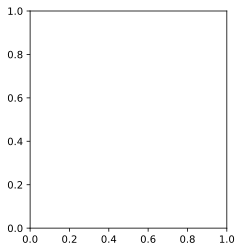

In [7]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

# 5. Transfert learning


## 5.1 VGG16 InceptionV3 Xception resnet50


# 6. Application


# 7. Conclusion et résultats